In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
df_stage = pd.read_csv("../results/gene_exp_analysis/cnv_genes_exp_stage.combine.csv",
                 header=0,sep="\t")
df = pd.read_csv("../results/gene_exp_analysis/cnv_genes_exp.combine.csv",
                 header=0,sep="\t")
label = pd.read_csv("../results/gene_exp_analysis/clinical.csv",
                    header=0,sep="\t")

In [3]:
df_stage.shape,df.shape

((647, 421), (21, 421))

In [4]:
label["OS"].value_counts()

OS
0    232
1    188
Name: count, dtype: int64

In [5]:
genes_ensemble_id = df["genes"]
df = df.drop(["genes"],axis=1)
genes_ensemble_id_stage = df_stage["genes"]
df_stage = df_stage.drop(["genes"],axis=1)

In [26]:
df = df.T
df.rename(columns=genes_ensemble_id,inplace=True)
df_stage = df_stage.T
df_stage.rename(columns=genes_ensemble_id_stage,inplace=True)

In [36]:
label["stage"]

sample
TCGA.2F.A9KQ.01A    2
TCGA.2F.A9KR.01A    2
TCGA.2F.A9KT.01A    3
TCGA.2F.A9KW.01A    2
TCGA.4Z.AA7M.01A    2
                   ..
TCGA.ZF.AA56.01A    2
TCGA.ZF.AA58.01A    1
TCGA.ZF.AA5H.01A    1
TCGA.ZF.AA5N.01A    1
TCGA.ZF.AA5P.01A    1
Name: stage, Length: 420, dtype: int64

In [41]:
df_stage["stage"] = label["stage"]

In [28]:
label= label.set_index('sample')

In [29]:
death_label=np.array([])
for sample in df.index:
    death_label = np.append(death_label,label.loc[sample]["OS"])

In [48]:
X = df_stage
y = death_label
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [49]:
from sklearn.manifold import TSNE
import plotly.express as px


features = X

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

fig = px.scatter(
    projections, x=0, y=1,
    color=y
)
fig.show()

In [50]:
from umap import UMAP
import plotly.express as px

umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=y
)

fig_2d.show()


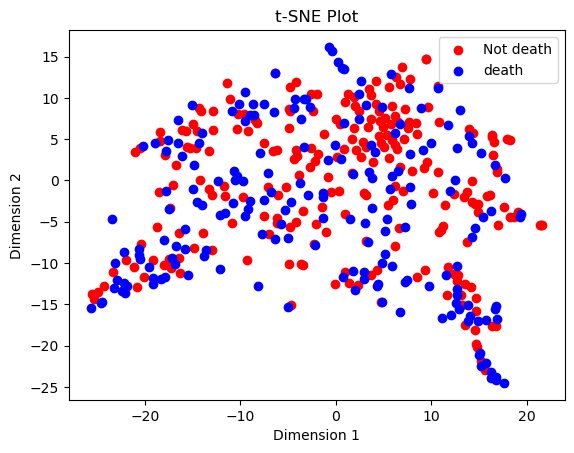

In [51]:
from sklearn.manifold import TSNE
# Assuming your data is stored in the variable 'data'
tsne = TSNE(n_components=2)
embedded_data = tsne.fit_transform(X)

# Step 2: Separate data points by class
class_1_indices = np.where(y == 0)[0]
class_2_indices = np.where(y == 1)[0]

class_1_data = embedded_data[class_1_indices]
class_2_data = embedded_data[class_2_indices]

# Step 3: Plot the t-SNE plot with different colors for each class
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], color='red', label='Not death')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], color='blue', label='death')

plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model=RandomForestClassifier(random_state=42)

# defining parameter range
param_grid_RF = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,12,14,16,20],
    'criterion' :['gini', 'entropy']
}

In [62]:
from sklearn.linear_model import RidgeClassifier
model=RidgeClassifier()
param_grid_Ridge = {'alpha':[0.001,0.01,0.1,1 ]}

In [55]:
grid = GridSearchCV(model, param_grid_RF, refit = True, verbose = 0)
  
# fitting the model for grid search
grid.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        73
         1.0       0.55      0.55      0.55        53

    accuracy                           0.62       126
   macro avg       0.61      0.61      0.61       126
weighted avg       0.62      0.62      0.62       126

